In [ ]:
from src.pipelines.ingestion_pipeline import run_ingestion
from src.pipelines.preprocessing_pipeline import run_preprocessing
from src.pipelines.feature_pipeline import run_feature_engineering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, accuracy_score, roc_curve,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif, RFE
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb

from catboost import CatBoostClassifier

import shap

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC


In [2]:
results_table = pd.DataFrame(columns=[
    'model_name', 'train_auc', 'test_auc',
    'best_threshold_acc', 'train_accuracy', 'test_accuracy',
    'best_threshold_f1', 'precision', 'sensitivity', 'f1_score'
])

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, results_df=None):
    if results_df is None:
        results_df = results_table.copy()

    X_train = np.asarray(X_train, dtype=np.float32)
    X_test = np.asarray(X_test, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.float32)

    if model_name == 'NN_model':
        print('NN')
    else:
        model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_train_pred = model.predict_proba(X_train)[:, 1]
        y_test_pred = model.predict_proba(X_test)[:, 1]
    else:
        y_train_pred = model.predict(X_train).flatten()
        y_test_pred = model.predict(X_test).flatten()

    print('y_train')
    print(np.isnan(y_train).any())
    print('y_trai_pred')
    print(np.isnan(y_train_pred).any())
    train_auc = roc_auc_score(y_train, y_train_pred)

    test_auc = roc_auc_score(y_test, y_test_pred)

    thresholds = np.linspace(0, 1, 250)
    train_accs = [accuracy_score(y_train, y_train_pred >= t) for t in thresholds]
    best_threshold_acc = thresholds[np.argmax(train_accs)]
    train_acc = max(train_accs)
    test_acc = accuracy_score(y_test, y_test_pred >= best_threshold_acc)

    f1_scores = [f1_score(y_train, y_train_pred >= t) for t in thresholds]
    best_threshold_f1 = thresholds[np.argmax(f1_scores)]

    y_test_bin_f1 = (y_test_pred >= best_threshold_f1).astype(int)
    precision = precision_score(y_test, y_test_bin_f1)
    recall = recall_score(y_test, y_test_bin_f1)
    f1 = f1_score(y_test, y_test_bin_f1)

    result_row = pd.DataFrame([{
        'model_name': model_name,
        'train_auc': round(train_auc, 4),
        'test_auc': round(test_auc, 4),
        'best_threshold_acc': round(best_threshold_acc, 4),
        'train_accuracy': round(train_acc, 4),
        'test_accuracy': round(test_acc, 4),
        'best_threshold_f1': round(best_threshold_f1, 4),
        'precision': round(precision, 4),
        'sensitivity': round(recall, 4),
        'f1_score': round(f1, 4)
    }])

    results_df = pd.concat([results_df, result_row], ignore_index=True)

    print(f"\n✅ Evaluation for {model_name}")
    print(f"AUC - Train: {train_auc:.4f}, Test: {test_auc:.4f}")
    print(f"Best Accuracy Threshold: {best_threshold_acc:.2f} | Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Best F1 Threshold: {best_threshold_f1:.2f} | Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.2f})")
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {test_auc:.2f})", linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle=':', color='grey')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_test, y_test_bin_f1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name} (Threshold: {best_threshold_f1:.2f})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.histplot(y_train_pred[y_train == 0], bins=50, color='blue', label='Class 0', stat='density', kde=True)
    sns.histplot(y_train_pred[y_train == 1], bins=50, color='red', label='Class 1', stat='density', kde=True)
    plt.axvline(best_threshold_f1, color='black', linestyle='--', label=f"Best F1 Threshold = {best_threshold_f1:.2f}")
    plt.title(f"Train Set: Predicted Probability Distribution - {model_name}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

In [3]:

raw_df = run_ingestion(data_dir='../Data', output_path='../Data/raw_data.parquet')
print(f"Ingested {len(raw_df)} rows of raw data.")


Ingested 500000 rows of raw data.


In [4]:

processed_df = run_preprocessing(
    raw_data_path='../Data/raw_data.parquet',
    output_path='../Data/processed_data.parquet'
)
print(f"Preprocessed {len(raw_df)} rows of raw data.")

Preprocessed 500000 rows of raw data.


In [5]:
processed_df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,country_u=t,country_m=t,countries_same,within_10pct,within_5pct
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,"{'lat': 54.710715, 'long': 15.368695}",mobile_payment,...,1994.074291,295.418413,0.163298,0.067491,0.132577,False,False,0,0.0,0.0
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,"{'lat': 58.897717, 'long': 30.25543}",debit_card,...,1016.169374,10.631611,0.23366,0.008981,0.017641,False,False,0,0.0,0.0
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.0,in-store,EUR,iOS,"{'lat': 42.684202, 'long': 3.843828}",debit_card,...,2556.977104,18.491301,0.540715,0.140258,0.275516,False,False,0,0.0,0.0
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,"{'lat': 44.296089, 'long': 15.749937}",mobile_payment,...,976.612531,0.224952,3.663265,0.007515,0.014763,False,False,0,0.0,0.0
95555,TX095555,2022-08-09 12:30:00,U00001,M0598,22.94,online,EUR,iOS,"{'lat': 46.209657, 'long': 28.773734}",credit_card,...,1039.774561,1.952922,1.082586,0.048023,0.094333,False,False,0,0.0,0.0


In [6]:
prepare_kwargs = dict(
    to_drop=['transaction_id', 'user_id', 'currency', 'location'],
    to_think_but_drop=['signup_date','Month_Year_EOM','Date','Year','time_diff','time_prev',
                       'latitude','longitude','lat_prev','lon_prev'],
    to_categorize=['channel','device','payment_method','category','country_merchant','sex',
                   'education','primary_source_of_income','country_users','part_of_day','transaction_country'],
    cutoff="2023-07-01",
    target="is_fraud",
)

X_train, y_train, X_test, y_test = run_feature_engineering(
    processed_data_path="../data/processed_data.parquet",
    X_train_path="../data/X_train.parquet",
    X_test_path ="../data/X_test.parquet",
    y_train_path="../data/y_train.parquet",
    y_test_path ="../data/y_test.parquet",
    **prepare_kwargs
)

In [11]:
# === Split & scale ===
X_train_fs, X_valid_fs, y_train_fs, y_valid_fs = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_fs),
    columns=X_train_fs.columns,
    index=X_train_fs.index
)
X_valid_scaled = pd.DataFrame(
    scaler.transform(X_valid_fs),
    columns=X_valid_fs.columns,
    index=X_valid_fs.index
)

cols_before = X_train_scaled.shape[1]
X_train_scaled = X_train_scaled.dropna(axis=1)
X_valid_scaled = X_valid_scaled[X_train_scaled.columns]
cols_after = X_train_scaled.shape[1]

# Container for selected features
selected_features = {}

# 1. ANOVA F-test
skb_f = SelectKBest(score_func=f_classif, k=10)
skb_f.fit(X_train_scaled, y_train_fs)
selected_features['F_test'] = list(X_train_scaled.columns[skb_f.get_support()])

# 2. Mutual Information
skb_mi = SelectKBest(score_func=mutual_info_classif, k=10)
skb_mi.fit(X_train_scaled, y_train_fs)
selected_features['Mutual_Info'] = list(X_train_scaled.columns[skb_mi.get_support()])

# 3. Recursive Feature Elimination
rfe = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=10)
rfe.fit(X_train_scaled, y_train_fs)
selected_features['RFE'] = list(X_train_scaled.columns[rfe.get_support()])

# 4. Random Forest Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_fs)
rf_imp = pd.Series(rf.feature_importances_, index=X_train_scaled.columns)
selected_features['RandomForest'] = list(rf_imp.nlargest(10).index)

# 5. XGBoost Importance
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train_fs)
xgb_imp = pd.Series(xgb.feature_importances_, index=X_train_scaled.columns)
selected_features['XGBoost'] = list(xgb_imp.nlargest(10).index)

# Combine top features
all_selected = [feat for feats in selected_features.values() for feat in feats]
final_feature_set = sorted(set(all_selected))

# Results
print("Selected features by method:")
for method, feats in selected_features.items():
    print(f"{method}: {feats}")
print(f"\nFinal unique selected features ({len(final_feature_set)}):")
print(final_feature_set)


Dropped 4 columns with NaN values


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:33] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features by method:
F_test: ['is_international', 'trust_score', 'has_fraud_history', 'risk_score', 'countries_same', 'country_merchant_Netherlands', 'sex_Female', 'transaction_country_Belgium', 'transaction_country_Spain', 'bad_rate']
Mutual_Info: ['is_first_time_merchant', 'has_fraud_history', 'payment_method_credit_card', 'payment_method_debit_card', 'sex_Male', 'education_Bachelor', 'education_Master', 'education_PhD', 'part_of_day_afternoon', 'part_of_day_morning']
RFE: ['is_international', 'risk_score', 'countries_same', 'country_merchant_Czech Republic', 'sex_Female', 'transaction_country_Belgium', 'transaction_country_Germany', 'transaction_country_Spain', 'transaction_country_Syria', 'bad_rate']
RandomForest: ['risk_score', 'distance_km', 'session_length_seconds', 'time_diff_hours', 'speed_kmph', 'sum_of_monthly_expenses', 'amount/sum_monthly_expenses', 'sum_of_monthly_installments', 'amount/sum_monthly_installments', 'amount']
XGBoost: ['bad_rate', 'transaction_countr

In [12]:
X_train = X_train[final_feature_set]
X_test = X_test[final_feature_set]

In [ ]:
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=10,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    verbosity=0,
    random_state=42
)

# Run cross-validation summary
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, xgb_model.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1])
    
    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


Fold 1 - Train AUC: 0.6079, Validation AUC: 0.5868
Fold 2 - Train AUC: 0.6082, Validation AUC: 0.5837
Fold 3 - Train AUC: 0.6078, Validation AUC: 0.5860
Fold 4 - Train AUC: 0.6069, Validation AUC: 0.5869
Fold 5 - Train AUC: 0.6088, Validation AUC: 0.5816

Average Train AUC: 0.6079
Average Validation AUC: 0.585


y_train
False
y_trai_pred
False


C:\Users\Jan\AppData\Local\Temp\ipykernel_16916\2349651536.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)



✅ Evaluation for XGBoost
AUC - Train: 0.6040, Test: 0.5819
Best Accuracy Threshold: 0.74 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.52 | Precision: 0.1078, Recall: 0.4971, F1: 0.1772


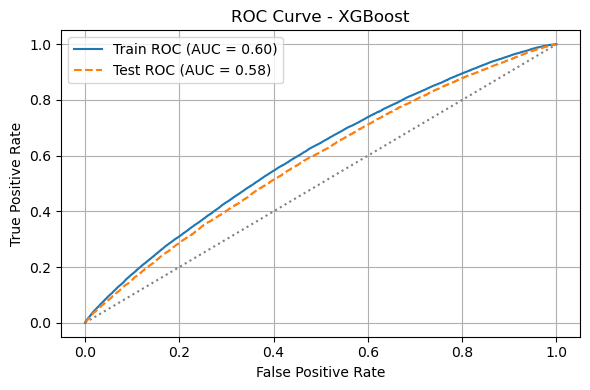

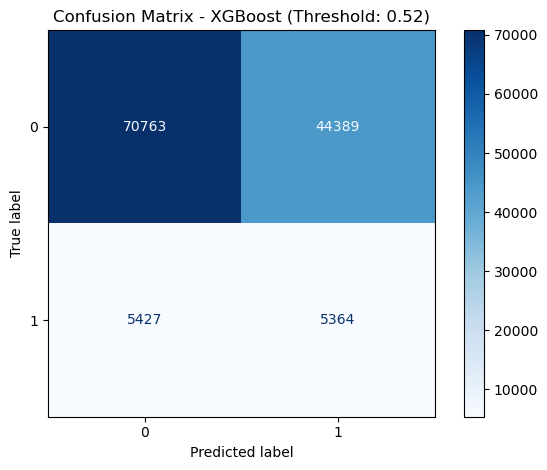

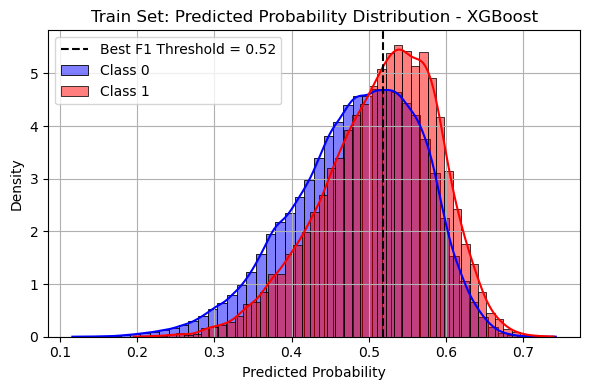

In [15]:
results_table = evaluate_model(xgb_model, "XGBoost", X_train, y_train, X_test, y_test, results_df=results_table)

In [ ]:
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=10,
    min_child_samples=20,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 5 fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lgb_model.fit(X_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, lgb_model.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, lgb_model.predict_proba(X_val)[:, 1])

    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


Fold 1 - Train AUC: 0.6080, Validation AUC: 0.5875
Fold 2 - Train AUC: 0.6081, Validation AUC: 0.5837
Fold 3 - Train AUC: 0.6079, Validation AUC: 0.5854
Fold 4 - Train AUC: 0.6067, Validation AUC: 0.5877
Fold 5 - Train AUC: 0.6084, Validation AUC: 0.5835

Average Train AUC: 0.6078
Average Validation AUC: 0.5856


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


y_train
False
y_trai_pred
False

✅ Evaluation for LGB
AUC - Train: 0.6041, Test: 0.5827
Best Accuracy Threshold: 0.72 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.53 | Precision: 0.1096, Recall: 0.4632, F1: 0.1773


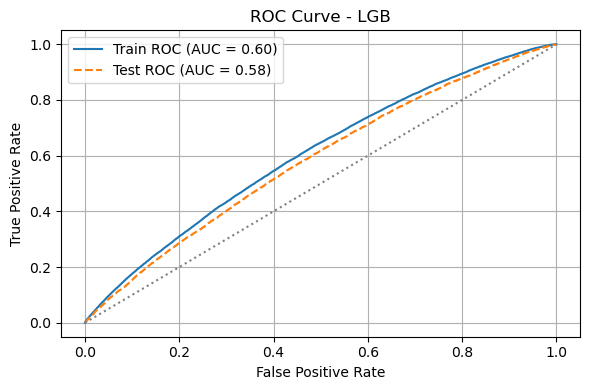

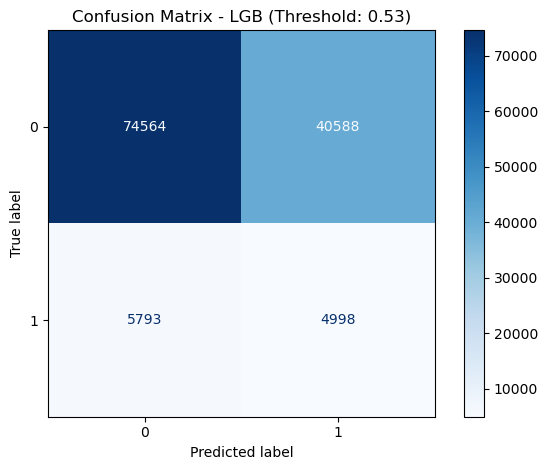

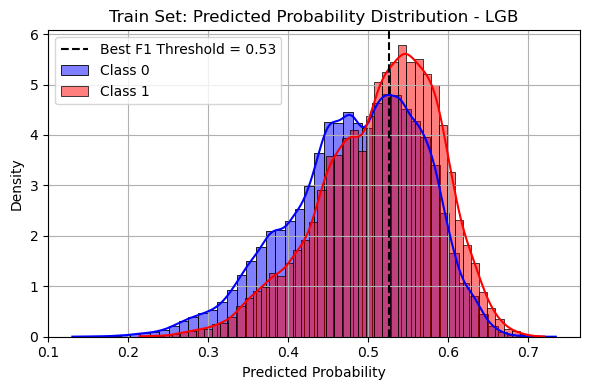

In [17]:
results_table = evaluate_model(lgb_model, "LGB", X_train, y_train, X_test, y_test, results_df=results_table)

In [ ]:


pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

catboost_model = CatBoostClassifier(
    iterations=150,
    learning_rate=0.05,          
    depth=4,                     
    l2_leaf_reg=10,              
    bagging_temperature=1.0,     
    scale_pos_weight=scale_pos_weight,
    verbose=0,
    random_seed=42,
    eval_metric='AUC',
    thread_count=-1
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    catboost_model.fit(X_tr, y_tr)
    y_tr_pred = catboost_model.predict_proba(X_tr)[:, 1]
    y_val_pred = catboost_model.predict_proba(X_val)[:, 1]

    tr_auc = roc_auc_score(y_tr, y_tr_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", np.mean(train_aucs).round(4))
print("Average Validation AUC:", np.mean(val_aucs).round(4))


Fold 1 - Train AUC: 0.5930, Validation AUC: 0.5895
Fold 2 - Train AUC: 0.5940, Validation AUC: 0.5862
Fold 3 - Train AUC: 0.5934, Validation AUC: 0.5892
Fold 4 - Train AUC: 0.5926, Validation AUC: 0.5894
Fold 5 - Train AUC: 0.5944, Validation AUC: 0.5843

Average Train AUC: 0.5935
Average Validation AUC: 0.5877


y_train
False
y_trai_pred
False

✅ Evaluation for CatBoost
AUC - Train: 0.5926, Test: 0.5854
Best Accuracy Threshold: 0.68 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.52 | Precision: 0.1085, Recall: 0.5107, F1: 0.1790


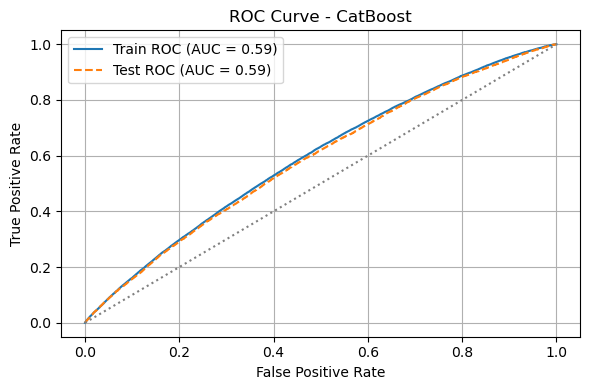

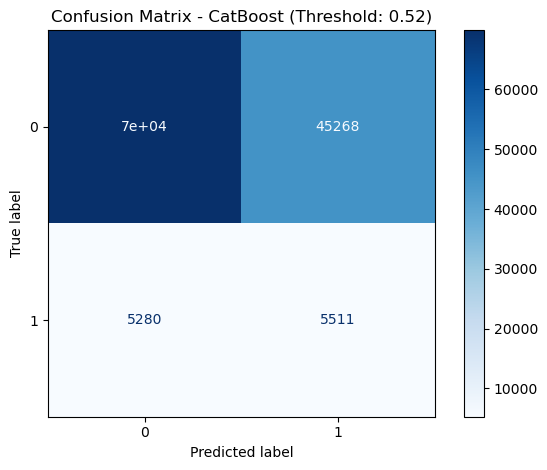

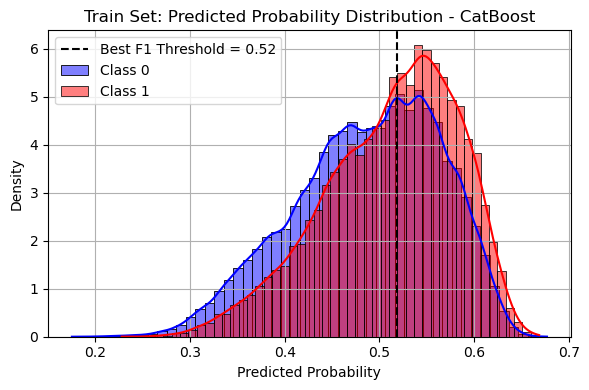

In [19]:
results_table = evaluate_model(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results_df=results_table)


📂 Fold 1


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - auc: 0.5067 - loss: 0.5342 - val_auc: 0.5110 - val_loss: 0.2965 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5138 - loss: 0.3023 - val_auc: 0.5696 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5318 - loss: 0.2979 - val_auc: 0.5825 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - auc: 0.5368 - loss: 0.2952 - val_auc: 0.5871 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5462 - loss: 0.2895 - val_auc: 0.5886 - val_loss: 0.2859 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5565 - loss: 0.2909 - val_auc: 0.5877 - val_loss: 0.2859 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5621 - loss: 0.2874 - val_auc: 0.5884 - val_loss: 0.2858 - learnin

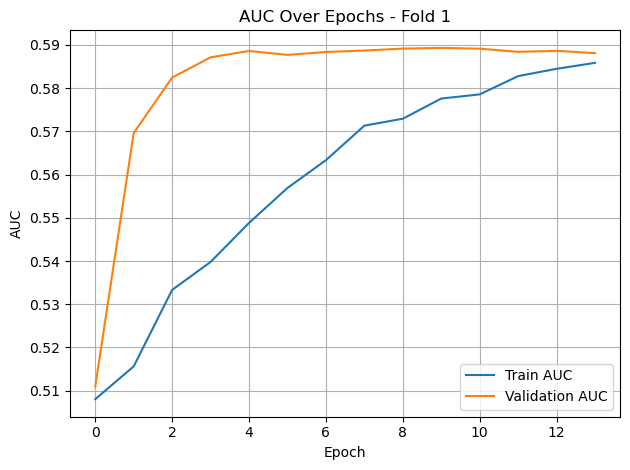


📂 Fold 2
Epoch 1/200


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5025 - loss: 0.5396 - val_auc: 0.5664 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5179 - loss: 0.3071 - val_auc: 0.5758 - val_loss: 0.2889 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5408 - loss: 0.2966 - val_auc: 0.5782 - val_loss: 0.2878 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5364 - loss: 0.2967 - val_auc: 0.5805 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5486 - loss: 0.2923 - val_auc: 0.5819 - val_loss: 0.2863 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5558 - loss: 0.2892 - val_auc: 0.5828 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5638 - loss: 0.2890 - val_auc: 0.5832 - val_loss: 0.2861 - learning_rate: 0.00

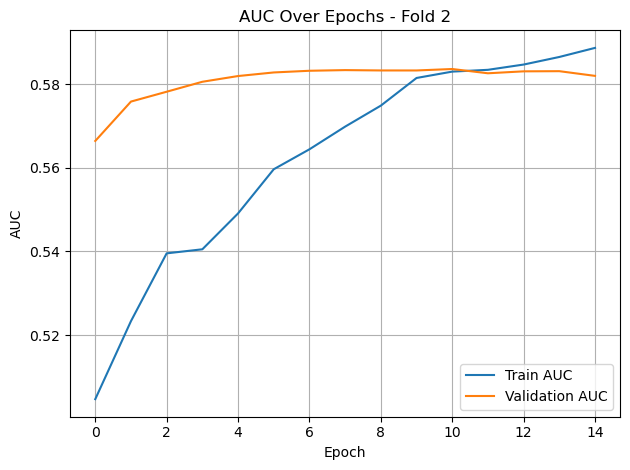


📂 Fold 3
Epoch 1/200


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.5025 - loss: 0.5386 - val_auc: 0.5684 - val_loss: 0.2954 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - auc: 0.5165 - loss: 0.3086 - val_auc: 0.5770 - val_loss: 0.2907 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5334 - loss: 0.2993 - val_auc: 0.5815 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5438 - loss: 0.2910 - val_auc: 0.5848 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5521 - loss: 0.2938 - val_auc: 0.5863 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5550 - loss: 0.2887 - val_auc: 0.5863 - val_loss: 0.2859 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5607 - loss: 0.2869 - val_auc: 0.5880 - val_loss: 0.2858 - learning_rate: 0.00

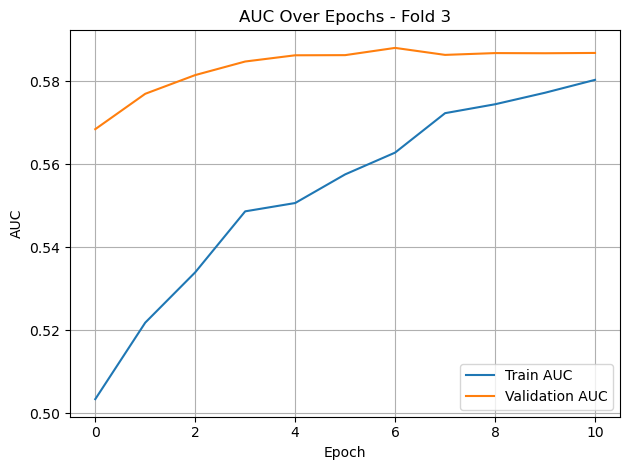


📂 Fold 4
Epoch 1/200


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5055 - loss: 0.5262 - val_auc: 0.5598 - val_loss: 0.2979 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5163 - loss: 0.3083 - val_auc: 0.5702 - val_loss: 0.2921 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - auc: 0.5246 - loss: 0.2992 - val_auc: 0.5820 - val_loss: 0.2888 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5388 - loss: 0.2938 - val_auc: 0.5854 - val_loss: 0.2871 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5476 - loss: 0.2935 - val_auc: 0.5874 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5562 - loss: 0.2936 - val_auc: 0.5876 - val_loss: 0.2859 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5626 - loss: 0.2892 - val_auc: 0.5865 - val_loss: 0.2859 - learning_rate: 0.00

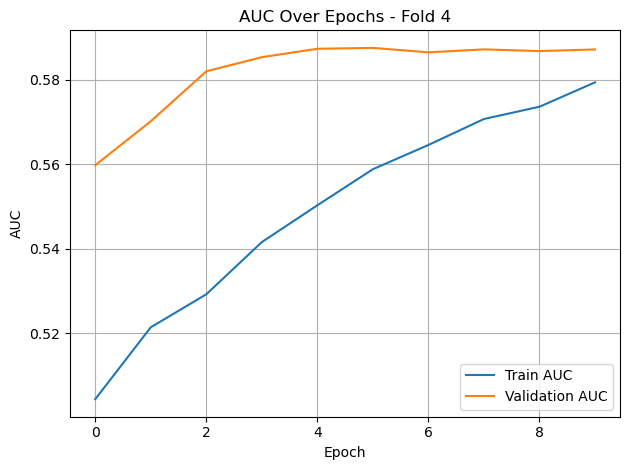


📂 Fold 5
Epoch 1/200


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5066 - loss: 0.5211 - val_auc: 0.5171 - val_loss: 0.2964 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - auc: 0.5215 - loss: 0.3046 - val_auc: 0.5685 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - auc: 0.5370 - loss: 0.2972 - val_auc: 0.5777 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5431 - loss: 0.2941 - val_auc: 0.5785 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5534 - loss: 0.2919 - val_auc: 0.5801 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5583 - loss: 0.2912 - val_auc: 0.5819 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5671 - loss: 0.2876 - val_auc: 0.5816 - val_loss: 0.2862 - learning_rate: 0.00

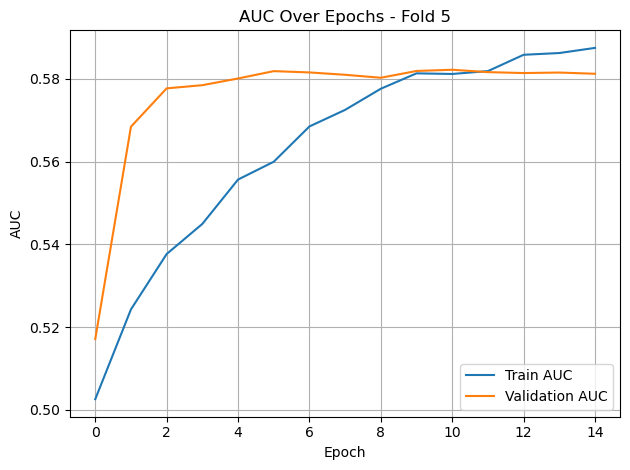


📊 Final Results:
Average Train AUC: 0.5944
Average Validation AUC: 0.5864

📦 Evaluating final NN model on full dataset
Epoch 1/200


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1305/1305 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - auc: 0.4996 - loss: 0.5119 - val_auc: 0.5555 - val_loss: 0.2975 - learning_rate: 0.0010
Epoch 2/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5183 - loss: 0.3041 - val_auc: 0.5740 - val_loss: 0.2928 - learning_rate: 0.0010
Epoch 3/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5377 - loss: 0.2947 - val_auc: 0.5807 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 4/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5479 - loss: 0.2916 - val_auc: 0.5814 - val_loss: 0.2895 - learning_rate: 0.0010
Epoch 5/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5535 - loss: 0.2884 - val_auc: 0.5827 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 6/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5703 - loss: 0.2878 - val_auc: 0.5833 - val_loss: 0.2891 - learning_rate: 0.0010
Epoch 7/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.5749 - loss: 0.2872 - val_auc: 0.5823 - val_loss: 0.2891 - learning_rate: 0.0

In [20]:


def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    adam_optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False
    )

    model.compile(optimizer=adam_optimizer, 
                  loss='binary_crossentropy', 
                  metrics=[AUC(name='auc')])
    return model

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"\n📂 Fold {fold}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    imputer = SimpleImputer(strategy='mean')
    X_tr = pd.DataFrame(imputer.fit_transform(X_tr), columns=X_tr.columns)
    X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

    y_tr = y_tr.astype(np.float32).values
    y_val = y_val.astype(np.float32).values

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)

    nn_model = create_nn_model(input_dim=X_tr_scaled.shape[1])
    history = nn_model.fit(
        X_tr_scaled, y_tr,
        validation_data=(X_val_scaled, y_val),
        epochs=200,
        batch_size=256,
        verbose=1,
        callbacks=[
            EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
        ]
    )

    y_tr_pred = nn_model.predict(X_tr_scaled).flatten()
    y_val_pred = nn_model.predict(X_val_scaled).flatten()

    tr_auc = roc_auc_score(y_tr, y_tr_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print(f"✅ Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f"AUC Over Epochs - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n📊 Final Results:")
print("Average Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


print("\n📦 Evaluating final NN model on full dataset")

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

y_train_array = y_train.astype(np.float32).values
y_test_array = y_test.astype(np.float32).values

final_nn_model = create_nn_model(input_dim=X_train_scaled.shape[1])
final_nn_model.fit(
    X_train_scaled, y_train_array,
    validation_data=(X_test_scaled, y_test_array),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    ]
)

In [21]:
imputer = SimpleImputer(strategy='mean')
X_t = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_tes = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Convert target dtype
y_t = y_train.astype(np.float32).values
y_tes = y_test.astype(np.float32).values

# Standardize features
scaler = StandardScaler()
X_t = scaler.fit_transform(X_t)
X_tes = scaler.transform(X_tes)

NN
10440/10440 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
y_train
False
y_trai_pred
False

✅ Evaluation for NN_model
AUC - Train: 0.5944, Test: 0.5829
Best Accuracy Threshold: 0.28 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.09 | Precision: 0.1077, Recall: 0.5101, F1: 0.1778


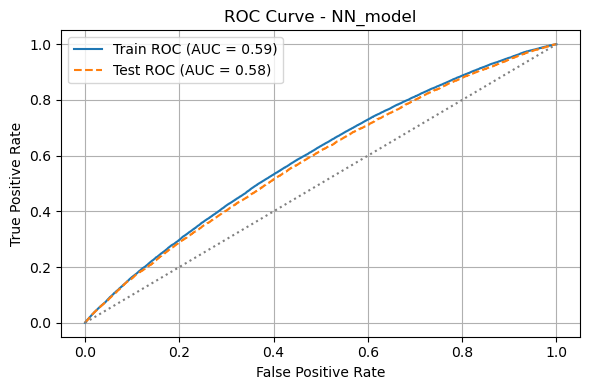

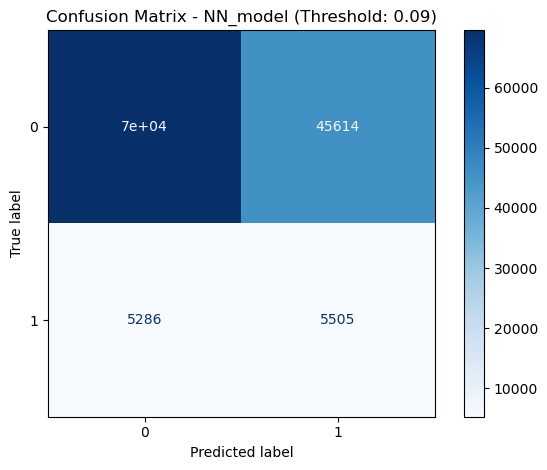

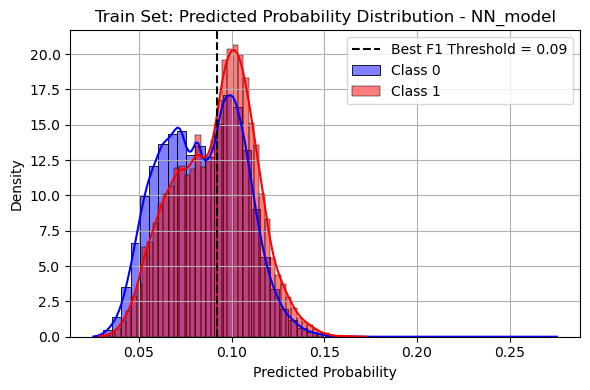

In [22]:
results_table = evaluate_model(nn_model, "NN_model", X_t, y_t, X_tes, y_tes, results_df=results_table)

In [23]:
results_table

,model_name,train_auc,test_auc,best_threshold_acc,train_accuracy,test_accuracy,best_threshold_f1,precision,sensitivity,f1_score
0,XGBoost,0.6040,0.5819,0.7390,0.9156,0.9143,0.5181,0.1078,0.4971,0.1772
1,LGB,0.6041,0.5827,0.7189,0.9156,0.9143,0.5261,0.1096,0.4632,0.1773
2,CatBoost,0.5926,0.5854,0.6787,0.9156,0.9143,0.5181,0.1085,0.5107,0.1790
3,NN_model,0.5944,0.5829,0.2771,0.9156,0.9143,0.0924,0.1077,0.5101,0.1778


### REGRESJA LOGISTYCZNA

In [24]:


pos = np.sum(y_t == 1)
neg = np.sum(y_t == 0)
scale_pos_weight = neg / pos                       
class_weight = {0: 1.0, 1: scale_pos_weight}

log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    class_weight=class_weight,
    random_state=42
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_t, y_t), 1):
    X_tr, X_val = X_t[train_idx], X_t[val_idx]
    y_tr, y_val = y_t[train_idx], y_t[val_idx]

    log_reg.fit(X_tr, y_tr)

    tr_auc  = roc_auc_score(y_tr,  log_reg.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, log_reg.predict_proba(X_val)[:, 1])

    print(f"Fold {fold} — Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:      {:.4f}".format(np.mean(train_aucs)))
print("Average Validation AUC: {:.4f}".format(np.mean(val_aucs)))



Fold 1 — Train AUC: 0.5893, Validation AUC: 0.5904
Fold 2 — Train AUC: 0.5902, Validation AUC: 0.5864
Fold 3 — Train AUC: 0.5893, Validation AUC: 0.5906
Fold 4 — Train AUC: 0.5893, Validation AUC: 0.5901
Fold 5 — Train AUC: 0.5905, Validation AUC: 0.5850

Average Train AUC:      0.5897
Average Validation AUC: 0.5885


y_train
False
y_trai_pred
False

✅ Evaluation for logistic_regression
AUC - Train: 0.5896, Test: 0.5844
Best Accuracy Threshold: 0.89 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.51 | Precision: 0.1090, Recall: 0.5085, F1: 0.1795


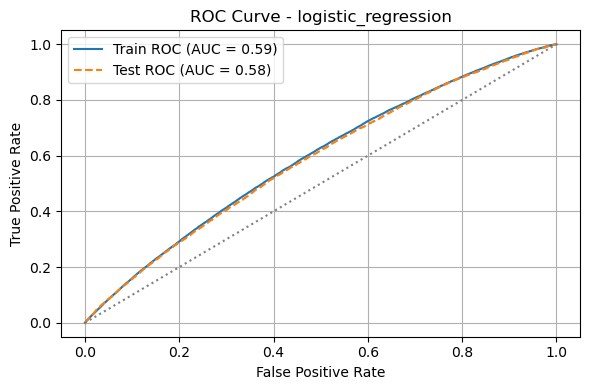

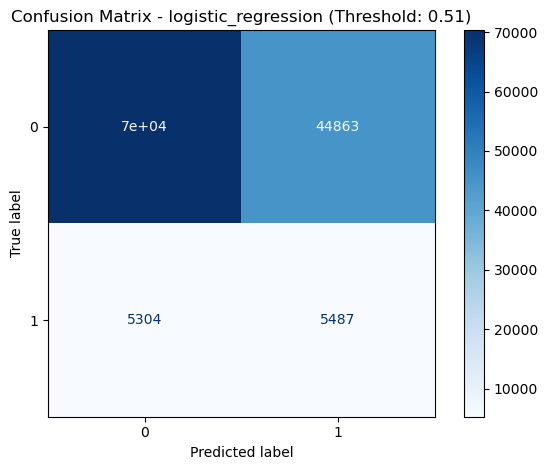

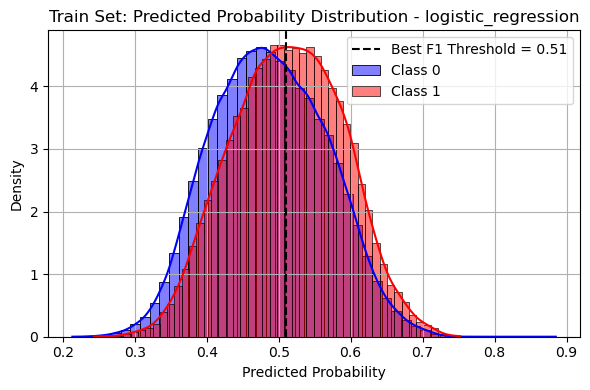

In [25]:
results_table = evaluate_model(log_reg, "logistic_regression", X_t, y_t, X_tes, y_tes, results_df=results_table)

In [26]:
results_table

,model_name,train_auc,test_auc,best_threshold_acc,train_accuracy,test_accuracy,best_threshold_f1,precision,sensitivity,f1_score
0,XGBoost,0.6040,0.5819,0.7390,0.9156,0.9143,0.5181,0.1078,0.4971,0.1772
1,LGB,0.6041,0.5827,0.7189,0.9156,0.9143,0.5261,0.1096,0.4632,0.1773
2,CatBoost,0.5926,0.5854,0.6787,0.9156,0.9143,0.5181,0.1085,0.5107,0.1790
3,NN_model,0.5944,0.5829,0.2771,0.9156,0.9143,0.0924,0.1077,0.5101,0.1778
4,logistic_regression,0.5896,0.5844,0.8876,0.9156,0.9143,0.5100,0.1090,0.5085,0.1795


In [ ]:
pos = np.sum(y_t == 1)
neg = np.sum(y_t == 0)
class_weight = {0: 1.0, 1: neg / pos}

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_t, y_t), 1):
    X_tr, X_val = X_t[train_idx], X_t[val_idx]
    y_tr, y_val = y_t[train_idx], y_t[val_idx]

    rf.fit(X_tr, y_tr)

    tr_auc = roc_auc_score(y_tr, rf.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])

    print(f"Fold {fold} — Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:      {:.4f}".format(np.mean(train_aucs)))
print("Average Validation AUC: {:.4f}".format(np.mean(val_aucs)))


Fold 1 — Train AUC: 0.5942, Validation AUC: 0.5866
Fold 2 — Train AUC: 0.5944, Validation AUC: 0.5822
Fold 3 — Train AUC: 0.5943, Validation AUC: 0.5853
Fold 4 — Train AUC: 0.5941, Validation AUC: 0.5848
Fold 5 — Train AUC: 0.5942, Validation AUC: 0.5808

Average Train AUC:      0.5943
Average Validation AUC: 0.5840


y_train
False
y_trai_pred
False

✅ Evaluation for random forest
AUC - Train: 0.5925, Test: 0.5812
Best Accuracy Threshold: 0.59 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.52 | Precision: 0.1094, Recall: 0.4637, F1: 0.1770


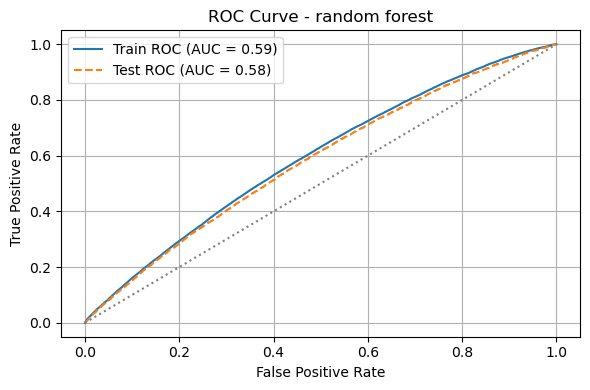

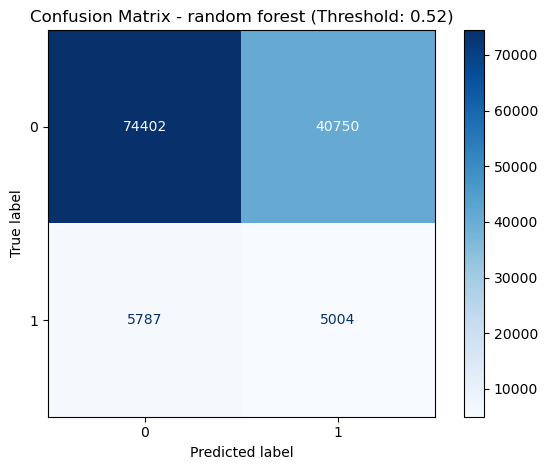

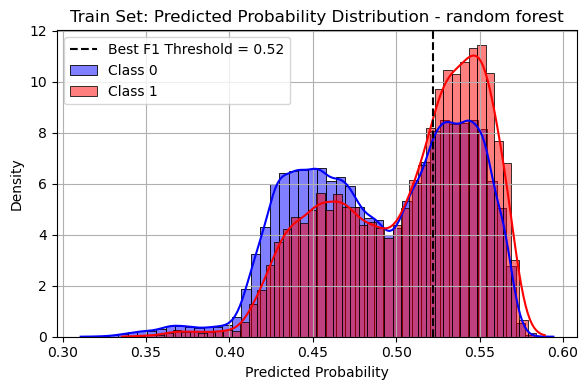

In [28]:
results_table = evaluate_model(rf, "random forest", X_t, y_t, X_tes, y_tes, results_df=results_table)

In [29]:
results_table

,model_name,train_auc,test_auc,best_threshold_acc,train_accuracy,test_accuracy,best_threshold_f1,precision,sensitivity,f1_score
0,XGBoost,0.6040,0.5819,0.7390,0.9156,0.9143,0.5181,0.1078,0.4971,0.1772
1,LGB,0.6041,0.5827,0.7189,0.9156,0.9143,0.5261,0.1096,0.4632,0.1773
2,CatBoost,0.5926,0.5854,0.6787,0.9156,0.9143,0.5181,0.1085,0.5107,0.1790
3,NN_model,0.5944,0.5829,0.2771,0.9156,0.9143,0.0924,0.1077,0.5101,0.1778
4,logistic_regression,0.5896,0.5844,0.8876,0.9156,0.9143,0.5100,0.1090,0.5085,0.1795
5,random forest,0.5925,0.5812,0.5944,0.9156,0.9143,0.5221,0.1094,0.4637,0.1770


### explaining model analysis:

In [30]:
fi = catboost_model.get_feature_importance(type='FeatureImportance')
fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': fi
}).sort_values('importance', ascending=False)
print("Feature Importance:")
fi_df.head(20)

Feature Importance:


,feature,importance
3,bad_rate,57.746176
22,risk_score,14.075402
6,countries_same,4.713332
17,is_international,3.652317
15,has_fraud_history,1.922963
1,amount/sum_monthly_expenses,1.597500
2,amount/sum_monthly_installments,1.523082
29,time_diff_hours,1.489932
26,speed_kmph,1.414921
11,distance_km,1.412210


Shap values plot

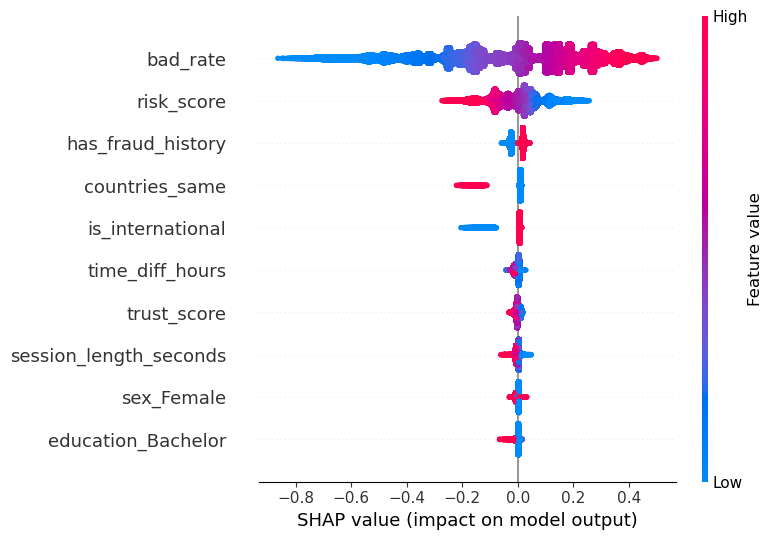

In [32]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=10)

Partial Dependence

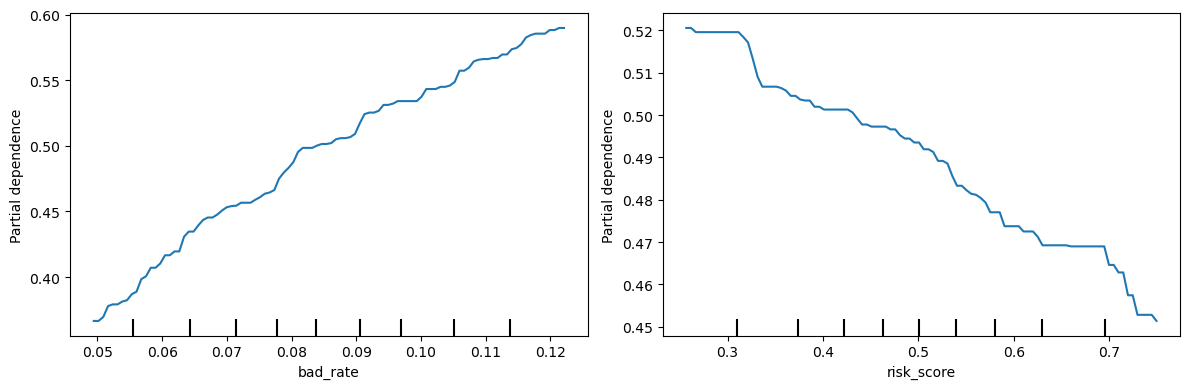

In [34]:
top_features = fi_df['feature'].head(2).tolist()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, feat in enumerate(top_features):
    display = PartialDependenceDisplay.from_estimator(
        catboost_model,
        X_train,
        [feat],
        ax=axes[i]
    )
plt.tight_layout()
plt.show()

Permutation Importance

In [35]:
test_result = permutation_importance(
    catboost_model,
    X_train,
    y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': test_result.importances_mean,
    'importance_std': test_result.importances_std
}).sort_values('importance_mean', ascending=False)
print("\nPermutation Importance:")
perm_df.head(10)


Permutation Importance:


,feature,importance_mean,importance_std
3,bad_rate,0.014545,0.000462
22,risk_score,0.001522,0.000305
11,distance_km,0.000283,0.000045
23,session_length_seconds,0.000157,0.000109
38,trust_score,0.000129,0.000080
35,transaction_country_Spain,0.000073,0.000068
36,transaction_country_Syria,0.000067,0.000026
32,transaction_country_Lithuania,0.000039,0.000009
30,transaction_country_Belgium,0.000036,0.000039
12,education_Bachelor,0.000033,0.000044


In [36]:
perm_df.tail(10)

,feature,importance_mean,importance_std
6,countries_same,-0.000267,0.000181
27,sum_of_monthly_expenses,-0.000285,0.000113
17,is_international,-0.000400,0.000212
0,amount,-0.001095,0.000097
1,amount/sum_monthly_expenses,-0.001106,0.000092
15,has_fraud_history,-0.002154,0.000155
26,speed_kmph,-0.004529,0.000101
29,time_diff_hours,-0.004756,0.000133
28,sum_of_monthly_installments,-0.006021,0.000118
2,amount/sum_monthly_installments,-0.006223,0.000144
